In [36]:
import pandas as pd
import numpy as np
import xgboost
import sklearn
assert sklearn.__version__ >= "0.20"
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [37]:
all_teams = pd.read_csv('all_teams_more_cleaned.csv')

In [38]:
# Extract win column
is_win = all_teams['isWin']
all_teams.drop(['isWin'], inplace=True, axis=1)

In [39]:
# Split into test and train
from sklearn.model_selection import train_test_split


all_teams_train, all_teams_test, is_win_train, is_win_test = train_test_split(all_teams, is_win, random_state=12)

In [40]:
from sklearn.metrics import roc_auc_score
import xgboost
xgb = xgboost.XGBClassifier()
xgb.fit(all_teams_train, is_win_train)


C:\Users\neilp\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

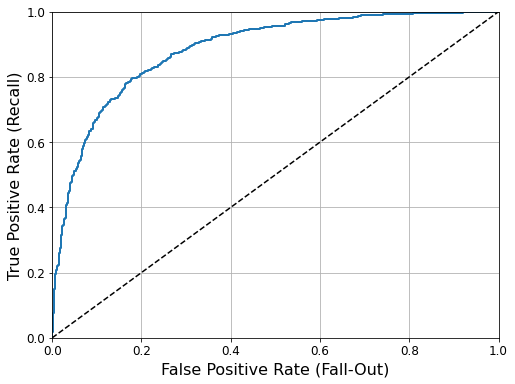

0.8850605428531444

In [41]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
precisions, recalls, thresholds = precision_recall_curve(is_win_test, xgb.predict_proba(all_teams_test)[:, 1])
fpr, tpr, thresholds = roc_curve(is_win_test, xgb.predict_proba(all_teams_test)[:, 1])


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
plt.show()


roc_auc_score(is_win_test, xgb.predict_proba(all_teams_test)[:, 1])

In [42]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(is_win_test, np.argmax(xgb.predict_proba(all_teams_test), axis=1))
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
score = cross_val_score(xgb, all_teams_test, is_win_test, scoring='accuracy', cv=cv, n_jobs=-1)
mean(score)


0.7680414294021483

>0 0.600 (0.040)
>1 0.627 (0.044)
>2 0.689 (0.029)
>3 0.766 (0.025)
>4 0.768 (0.031)
>5 0.750 (0.031)


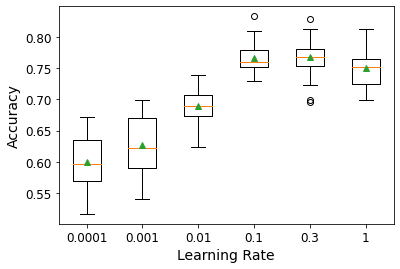

In [48]:
# Test Models
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
from numpy import mean
from xgboost import XGBClassifier
from numpy import std

def get_models():
	models = dict()
	rates = [0.0001, 0.001, 0.01, 0.1, 0.3, 1.0]
	for n in range(len(rates)):
		models[n] = XGBClassifier(eta=rates[n])
	
	return models

def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, all_teams_test, is_win_test, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

models = get_models()
results = list()
names = ['0.0001', '0.001', '0.01', '0.1', '0.3', '1']
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Learning Rate")
pyplot.ylabel("Accuracy")
pyplot.show()

<AxesSubplot:>

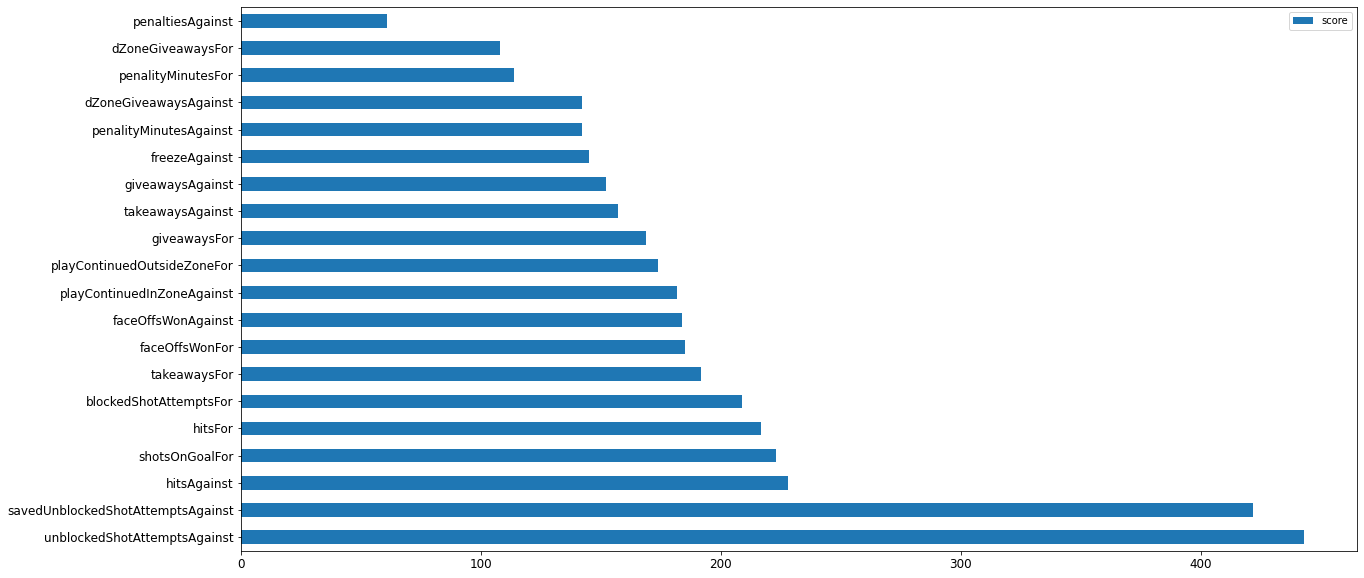

In [57]:
# Important Features

feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features